<a href="https://colab.research.google.com/github/maegop/TensorFlow-Pokemon-Course/blob/main/Pokemon_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokemon Stats

This database includes 21 variables per each of the 721 Pokémon of the first six generations, plus the Pokémon ID and its name.

The dataset we'll be using is the compilation of stats and traits for the Pokémon video games. Pokémon is a popular game for generations of Nintendo handheld video game consoles where players collect and train animal-like creatures called Pokémon. We'll be creating a model to try to predict whether a Pokémon is a legendary Pokémon, a rare type of Pokémon who's the only one of its species.

There are a lot of existing compilations of Pokémon stats, but we'll be using a .CSV version found on Kaggle. There's a download button on the website, so save the file to your computer and we can begin.

Import data

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

download_url = 'https://www.kaggle.com/alopez247/pokemon'

od.download(download_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maegop
Your Kaggle Key: ··········


100%|██████████| 715k/715k [00:00<00:00, 67.0MB/s]

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [6]:
df = pd.read_csv('/content/pokemon/pokemon_alopez247.csv')

In [7]:
df.columns

Index(['Number', 'Name', 'Type_1', 'Type_2', 'Total', 'HP', 'Attack',
       'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary',
       'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2',
       'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate',
       'Body_Style'],
      dtype='object')

We'll narrow our focus a little and only select categories we think will be relevant

In [8]:
df = df[['isLegendary','Generation', 'Type_1', 'Type_2', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed','Color','Egg_Group_1','Height_m','Weight_kg','Body_Style']]


In [9]:
df

,isLegendary,Generation,Type_1,Type_2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Color,Egg_Group_1,Height_m,Weight_kg,Body_Style
0,False,1,Grass,Poison,45,49,49,65,65,45,Green,Monster,0.71,6.9,quadruped
1,False,1,Grass,Poison,60,62,63,80,80,60,Green,Monster,0.99,13.0,quadruped
2,False,1,Grass,Poison,80,82,83,100,100,80,Green,Monster,2.01,100.0,quadruped
3,False,1,Fire,NaN,39,52,43,60,50,65,Red,Monster,0.61,8.5,bipedal_tailed
4,False,1,Fire,NaN,58,64,58,80,65,80,Red,Monster,1.09,19.0,bipedal_tailed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,True,6,Dark,Flying,126,131,95,131,98,99,Red,Undiscovered,5.79,203.0,two_wings
717,True,6,Dragon,Ground,108,100,121,81,95,95,Green,Undiscovered,5.00,305.0,serpentine_body
718,True,6,Rock,Fairy,50,100,150,100,150,50,Pink,Undiscovered,0.71,8.8,head_arms
719,True,6,Psychic,Ghost,80,110,60,150,130,70,Purple,Undiscovered,0.51,9.0,head_only


**Correlation between different pokemon stats**

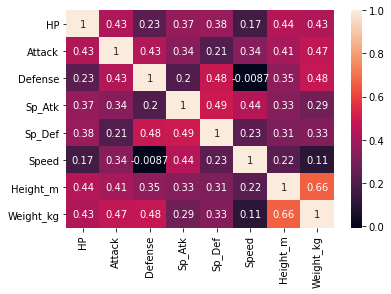

In [32]:
import seaborn as sns
pokemon_stats = df[["HP","Attack","Defense","Sp_Atk","Sp_Def","Speed","Height_m","Weight_kg"]]
corr = pokemon_stats.corr()
sns.heatmap(corr,annot = True)

### Normalization

Format the data to be read by the model.
* Make sure all the data is numerical. 

A few of the categories aren't numerical however. One example is the category that we'll be training our model to detect: the "isLegendary" column of data. These are the labels that we will eventually separate from the rest of the data and use as an answer key for the model's training. We'll convert this column from boolean "False" and "True" statements to the equivalent "0" and "1" integ

In [10]:
df['isLegendary'] = df['isLegendary'].astype(int)
df['isLegendary']

0      0
1      0
2      0
3      0
4      0
      ..
716    1
717    1
718    1
719    1
720    1
Name: isLegendary, Length: 721, dtype: int64

Converting data to numbers could be just assign a number to each category, such as: Water = 1, Fire = 2, Grass = 3 and so on. But this isn't a good idea because these numerical assignments aren't ordinal; they don't lie on a scale. By doing this, we would be implying that Water is closer to Fire than it is Grass, which doesn't really make sense.

The solution to this is to create dummy variables. By doing this we'll be creating a new column for each possible variable. There will be a column called "Water" that would be a 1 if it was a water Pokémon, and a 0 if it wasn't. Then there will be another column called "Fire" that would be a 1 if it was a fire Pokémon, and so forth for the rest of the types. This prevents us from implying any pattern or direction among the types.

In [11]:
def dummy_creation(df, dummy_categories):
    for i in dummy_categories:
        df_dummy = pd.get_dummies(df[i])
        df = pd.concat([df,df_dummy],axis=1)
        df = df.drop(i, axis=1)
    return(df)

This function first uses pd.get_dummies to create a dummy DataFrame of that category. As it's a seperate DataFrame, we'll need to concatenate it to our original DataFrame. And since we now have the variables represented properly as separate columns, we drop the original column. Having this in a function is nice because we can quickly do this for many categories:

In [12]:
df = dummy_creation(df, ['Egg_Group_1', 'Body_Style', 'Color','Type_1', 'Type_2'])
df

,isLegendary,Generation,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Height_m,Weight_kg,Amorphous,Bug,Ditto,Dragon,Fairy,Field,Flying,Grass,Human-Like,Mineral,Monster,Undiscovered,Water_1,Water_2,Water_3,bipedal_tailed,bipedal_tailless,four_wings,head_arms,head_base,head_legs,head_only,insectoid,multiple_bodies,quadruped,serpentine_body,several_limbs,two_wings,with_fins,Black,...,Purple,Red,White,Yellow,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0,1,45,49,49,65,65,45,0.71,6.9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,60,62,63,80,80,60,0.99,13.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,80,82,83,100,100,80,2.01,100.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,1,39,52,43,60,50,65,0.61,8.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,58,64,58,80,65,80,1.09,19.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,1,6,126,131,95,131,98,99,5.79,203.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
717,1,6,108,100,121,81,95,95,5.00,305.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
718,1,6,50,100,150,100,150,50,0.71,8.8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
719,1,6,80,110,60,150,130,70,0.51,9.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


***The importance of creating dummy variables***
* Some categories are not numerical.
* Converting multiple categories into numbers implies that they are on a scale.
* The categories for "Type_1" should all be boolean (0 or 1).


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 85 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   isLegendary       721 non-null    int64  
 1   Generation        721 non-null    int64  
 2   HP                721 non-null    int64  
 3   Attack            721 non-null    int64  
 4   Defense           721 non-null    int64  
 5   Sp_Atk            721 non-null    int64  
 6   Sp_Def            721 non-null    int64  
 7   Speed             721 non-null    int64  
 8   Height_m          721 non-null    float64
 9   Weight_kg         721 non-null    float64
 10  Amorphous         721 non-null    uint8  
 11  Bug               721 non-null    uint8  
 12  Ditto             721 non-null    uint8  
 13  Dragon            721 non-null    uint8  
 14  Fairy             721 non-null    uint8  
 15  Field             721 non-null    uint8  
 16  Flying            721 non-null    uint8  
 1

### Split data for ML model

In [14]:
def train_test_splitter(DataFrame, column):
    df_train = DataFrame.loc[df[column] != 1]
    df_test = DataFrame.loc[df[column] == 1]

    df_train = df_train.drop(column, axis=1)
    df_test = df_test.drop(column, axis=1)

    return(df_train, df_test)

df_train, df_test = train_test_splitter(df, 'Generation')

In [15]:
def label_delineator(df_train, df_test, label):
    
    train_data = df_train.drop(label, axis=1).values
    train_labels = df_train[label].values
    test_data = df_test.drop(label,axis=1).values
    test_labels = df_test[label].values
    return(train_data, train_labels, test_data, test_labels)

In [16]:
train_data, train_labels, test_data, test_labels = label_delineator(df_train, df_test, 'isLegendary')

### Split and Normalizing data

Now we can get to the machine learning! Let's create the model using Keras. Keras is an API for Tensorflow. We have a few options for doing this, but we'll keep it simple for now. A model is built upon layers. We'll add two fully connected neural layers.

The number associated with the layer is the number of neurons in it. The first layer we'll use is a 'ReLU' (Rectified Linear Unit)' activation function. Since this is also the first layer, we need to specify input_size, which is the shape of an entry in our dataset.

After that, we'll finish with a softmax layer. Softmax is a type of logistic regression done for situations with multiple cases, like our 2 possible groups: 'Legendary' and 'Not Legendary'. With this we delineate the possible identities of the Pokémon into 2 probability groups corresponding to the possible labels:


In [17]:
def data_normalizer(train_data, test_data):
    train_data = preprocessing.MinMaxScaler().fit_transform(train_data)
    test_data = preprocessing.MinMaxScaler().fit_transform(test_data)
    return(train_data, test_data)

train_data, test_data = data_normalizer(train_data, test_data)

In [18]:
length = train_data.shape[1]

model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_shape=[length,]))
model.add(keras.layers.Dense(2, activation='softmax'))

### Compile and Evaluate Model 

Model compilation and fiting the data to the model.

Here we're just feeding three parameters to model.compile. We pick an optimizer, which determines how the model is updated as it gains information, a loss function, which measures how accurate the model is as it trains, and metrics, which specifies which information it provides so we can analyze the model.

The optimizer we're using is the Stochastic Gradient Descent (SGD) optimization algorithm, but there are others available. For our loss we're using sparse_categorical_crossentropy. If our values were one-hot encoded, we would want to use "categorial_crossentropy" instead.

In [19]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(train_data, train_labels, epochs=400)

Epoch 1/400
18/18 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.8014
Epoch 2/400
18/18 [==============================] - 0s 1ms/step - loss: 0.4585 - accuracy: 0.9389
Epoch 3/400
18/18 [==============================] - 0s 1ms/step - loss: 0.3877 - accuracy: 0.9286
Epoch 4/400
18/18 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.9193
Epoch 5/400
18/18 [==============================] - 0s 1ms/step - loss: 0.3048 - accuracy: 0.9361
Epoch 6/400
18/18 [==============================] - 0s 2ms/step - loss: 0.2701 - accuracy: 0.9456
Epoch 7/400
18/18 [==============================] - 0s 2ms/step - loss: 0.2843 - accuracy: 0.9290
Epoch 8/400
18/18 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.9303
Epoch 9/400
18/18 [==============================] - 0s 1ms/step - loss: 0.2966 - accuracy: 0.9137
Epoch 10/400
18/18 [==============================] - 0s 1ms/step - loss: 0.2522 - accuracy: 0.9343
Epoch 11/

The three parameters **model.fit** needs are our training data, our training labels, and the number of epochs. One epoch is when the model has iterated over every sample once. Essentially the number of epochs is equal to the number of times we want to cycle through the data. We'll start with just 1 epoch, and then show that increasing the epoch improves the results.

***Model testing*** 
**model.evaluate** will evaluate how strong our model is with the test data, and report that in the form of loss value and accuracy value (since we specified ***accuracy*** in our ***selected_metrics*** variable when we compiled the model). We'll just focus on our *accuracy* for now. With an accuracy of ~98%, it's not perfect, but it's very accurate.

In [22]:
loss_value, accuracy_value = model.evaluate(test_data, test_labels)
print(f'Our test accuracy was {accuracy_value}')

5/5 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9801
Our test accuracy was 0.9801324605941772


We can also use our model to predict specific Pokémon, or at least have it tell us which status the Pokémon is most likely to have, with model.predict. All it needs to predict a Pokémon is the data for that Pokémon itself. We're providing that by selecting a certain index of test_data:

In [23]:
def predictor(test_data, test_labels, index):
    prediction = model.predict(test_data)
    if np.argmax(prediction[index]) == test_labels[index]:
        print(f'This was correctly predicted to be a \"{test_labels[index]}\"!')
    else:
        print(f'This was incorrectly predicted to be a \"{np.argmax(prediction[index])}\". It was actually a \"{test_labels[index]}\".')
        return(prediction)

Let's look at one of the more well-known legendary Pokémon: Mewtwo. He's number 150 in the list of Pokémon, so we'll look at index 149:

In [29]:
predictor(test_data, test_labels, 149)

This was correctly predicted to be a "1"!
